<a href="https://colab.research.google.com/github/Kevin-M-Smith/DocumentClassification/blob/main/2023_02_08_TestingOffTheShelfModels_RVL_CDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This note book downloads a few sample images from the Flint dataset and runs them through two off-the-shelf fine-tuned models for the RVL-CDIP dataset to see what it thinks of them.

# Install Dependencies
## Models and Datasets 

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install transformers[sentencepiece] datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Libraries

In [2]:
import urllib.request
from PIL import Image

import re
import time

import torch
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, DonutProcessor, VisionEncoderDecoderModel

# Download Sample Images

In [3]:
sample_image_filenames = [
    "DTMB001_0127.png", 
    "DTMB001_0252.png",
    "Staff_4_0226.png",
    "Staff_9_1117.png",
    "Staff_10_0082.png",
    "Staff_16_0221.png",

    "deq24_1427.jp2",
    "deq24_1638.jp2",
    "DTMB005_2151.jp2",
    "DTMB014_8958.jp2",
    "DTMB014_9029.jp2",
    "DTMB014_9107.jp2",
    "DTMB033_2921.jp2",
    "DTMB033_2987.jp2",
    "GOV004_4140.jp2",
    "GOV004_4171.jp2",
    "Staff_1_0757.jp2",
    "Staff_1_0868.jp2",

   ]

for filename in sample_image_filenames:
  url = f"https://waterdiplomacyhandbook.com/wp-content/uploads/2022/07/flint_images/{filename}"
  print(f"Downloading {url} ...")
  urllib.request.urlretrieve(url=url, filename = filename)


# Prepare Models
## DiT

*   description: https://huggingface.co/docs/transformers/model_doc/dit
*   models from: https://huggingface.co/models?other=dit
    * note there is a "large" fine-tuned version, we are using the smaller base version
*   originally proposed July 2022: https://arxiv.org/abs/2203.02378




In [4]:
dit_feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")
dit_model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")

def get_class_of_image_from_dit(image_filepath: str) -> str:
  image = Image.open(image_filepath).convert('RGB')
  inputs = dit_feature_extractor(images=image, return_tensors="pt")
  outputs = dit_model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  return dit_model.config.id2label[predicted_class_idx]

/usr/local/lib/python3.8/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/beit/image_processing_beit.py:111: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## Donut

*   description: https://huggingface.co/docs/transformers/model_doc/donut
*   models from: https://huggingface.co/naver-clova-ix/donut-base-finetuned-rvlcdip
*   originally proposed in November 2021: https://arxiv.org/abs/2111.15664



In [5]:
donut_processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")
donut_model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
def get_class_of_image_from_donut(image_filepath: str) -> str:
    image = Image.open(image_filepath).convert("RGB")
    pixel_values = donut_processor(image, return_tensors="pt").pixel_values

    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = donut_processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    donut_model.to(device)

    outputs = donut_model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=donut_model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=donut_processor.tokenizer.pad_token_id,
                                eos_token_id=donut_processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[donut_processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True,)
  
    seq = donut_processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(donut_processor.tokenizer.eos_token, "").replace(donut_processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    json = donut_processor.token2json(seq)
    return json['class']

# Test models on sample images

In [7]:
# how wide should the image printed to the screen be?
basewidth = 500

def show_image_preview(image_filepath: str) -> None:
  img = Image.open(filename)
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((basewidth,hsize), Image.LANCZOS)
  display(img)

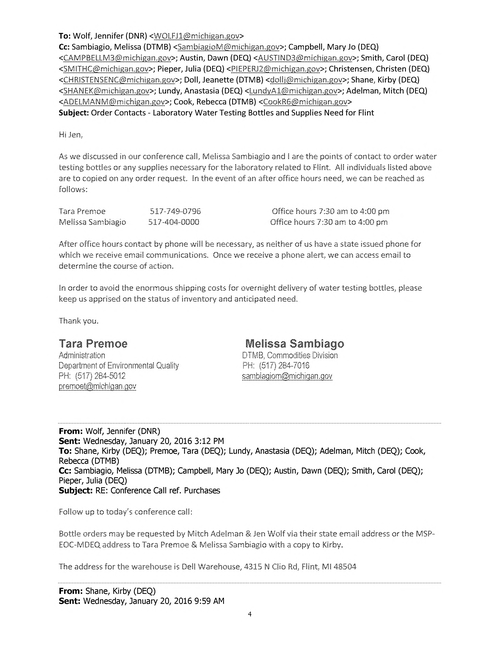

DIT determined DTMB001_0127.png is a(n) email in 1.61 seconds.
Donut determined DTMB001_0127.png is a(n) email in 91.66 seconds.


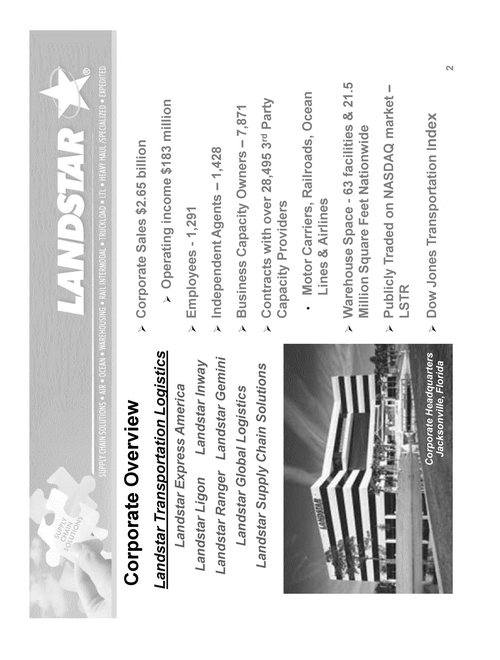

DIT determined DTMB001_0252.png is a(n) presentation in 1.26 seconds.
Donut determined DTMB001_0252.png is a(n) presentation in 82.81 seconds.


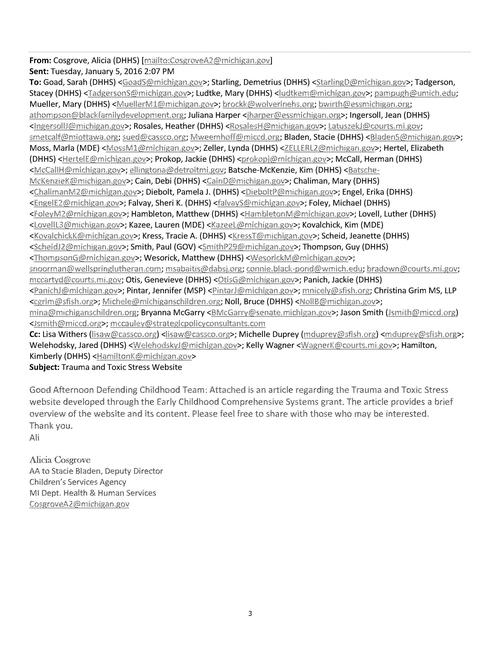

DIT determined Staff_4_0226.png is a(n) email in 1.34 seconds.
Donut determined Staff_4_0226.png is a(n) email in 83.05 seconds.


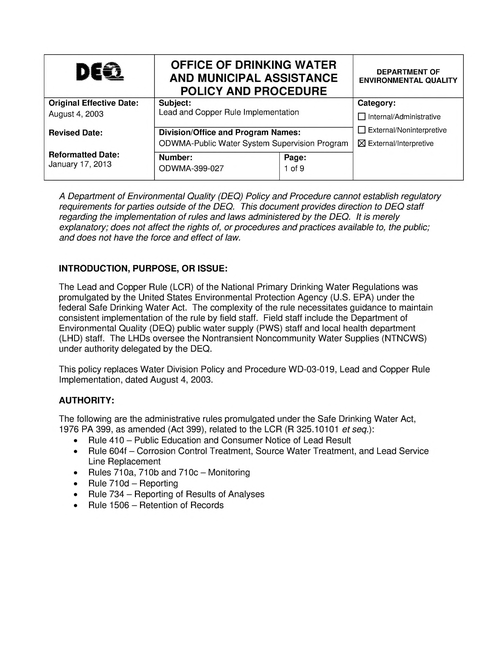

DIT determined Staff_9_1117.png is a(n) scientific report in 1.36 seconds.
Donut determined Staff_9_1117.png is a(n) form in 87.84 seconds.


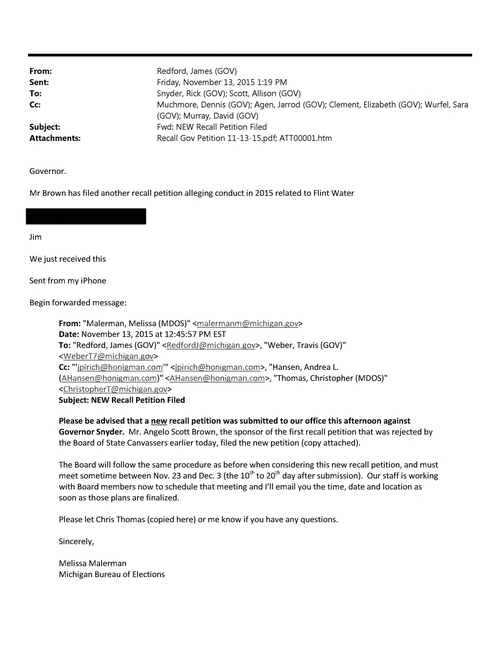

DIT determined Staff_10_0082.png is a(n) email in 0.89 seconds.
Donut determined Staff_10_0082.png is a(n) email in 87.29 seconds.


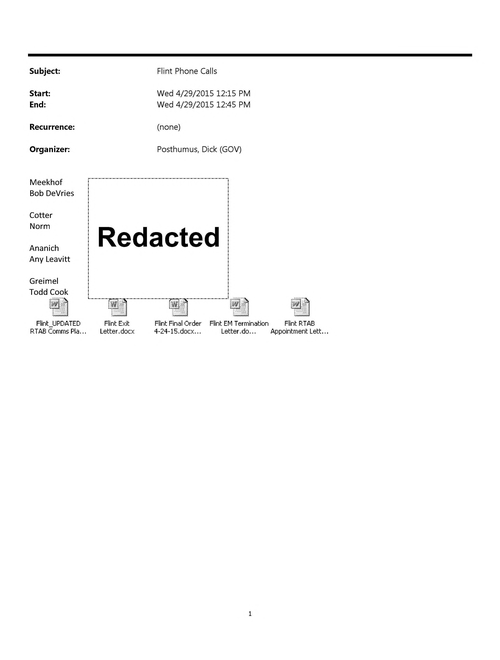

DIT determined Staff_16_0221.png is a(n) email in 0.85 seconds.
Donut determined Staff_16_0221.png is a(n) email in 90.08 seconds.


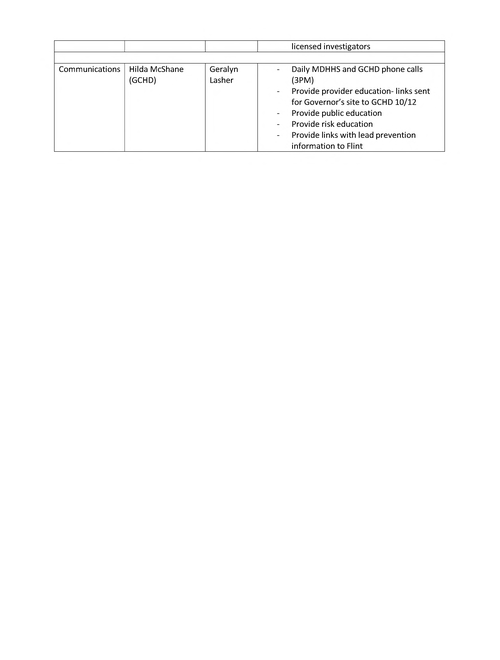

DIT determined deq24_1427.jp2 is a(n) scientific report in 1.26 seconds.
Donut determined deq24_1427.jp2 is a(n) email in 85.77 seconds.


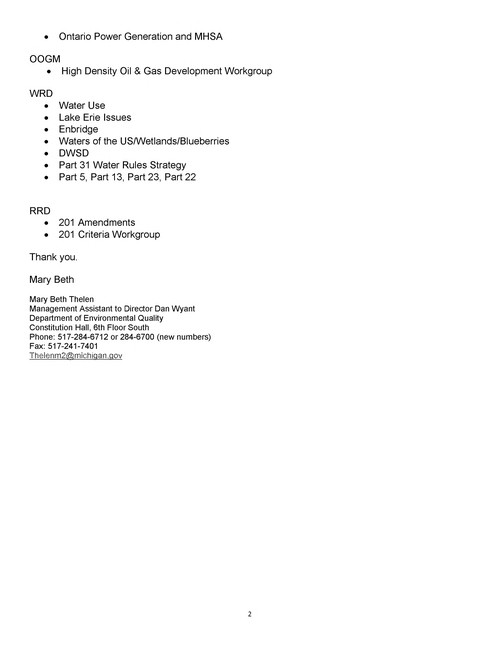

DIT determined deq24_1638.jp2 is a(n) email in 1.27 seconds.
Donut determined deq24_1638.jp2 is a(n) presentation in 85.22 seconds.


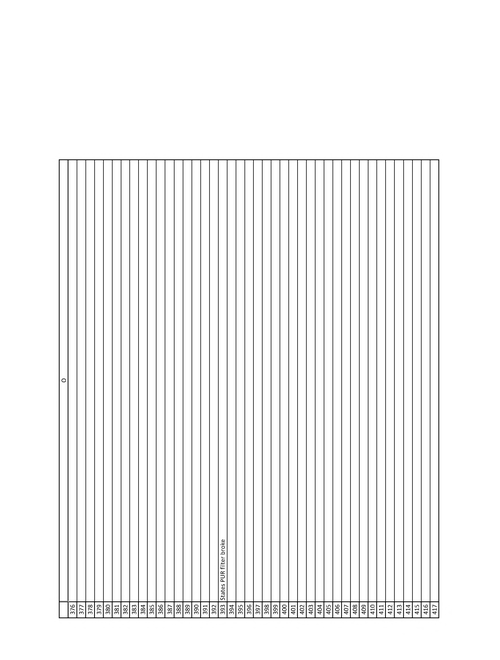

DIT determined DTMB005_2151.jp2 is a(n) email in 1.95 seconds.
Donut determined DTMB005_2151.jp2 is a(n) questionnaire in 83.94 seconds.


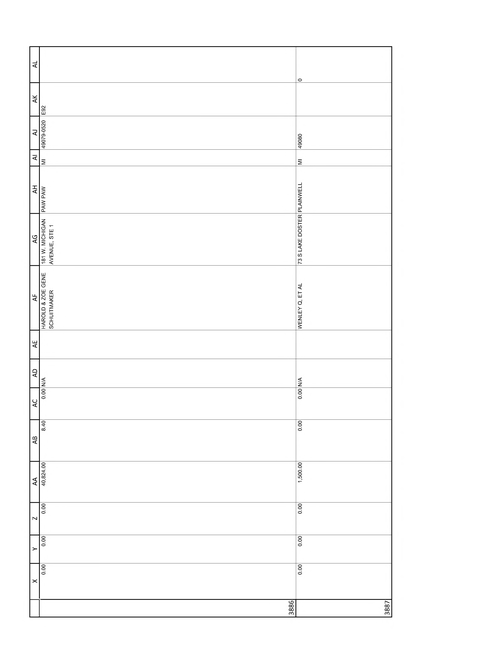

DIT determined DTMB014_8958.jp2 is a(n) invoice in 1.93 seconds.
Donut determined DTMB014_8958.jp2 is a(n) budget in 84.26 seconds.


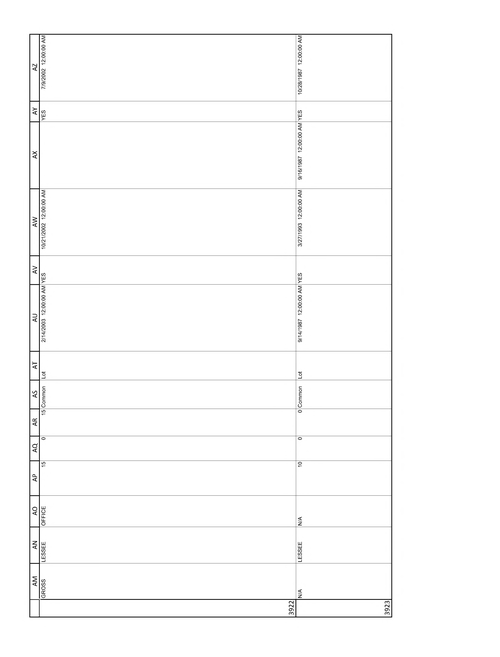

DIT determined DTMB014_9029.jp2 is a(n) invoice in 5.39 seconds.
Donut determined DTMB014_9029.jp2 is a(n) form in 89.29 seconds.


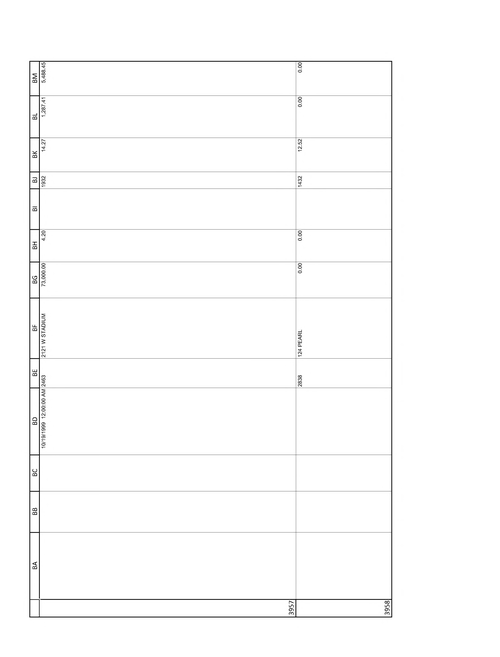

DIT determined DTMB014_9107.jp2 is a(n) form in 1.24 seconds.
Donut determined DTMB014_9107.jp2 is a(n) scientific_report in 85.35 seconds.


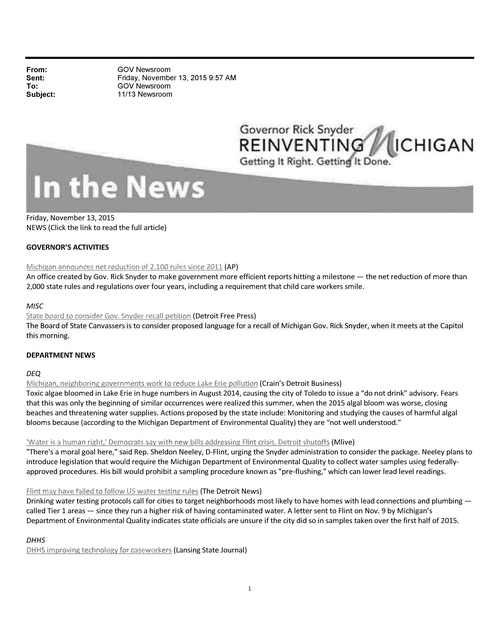

DIT determined DTMB033_2921.jp2 is a(n) email in 1.76 seconds.
Donut determined DTMB033_2921.jp2 is a(n) email in 86.98 seconds.


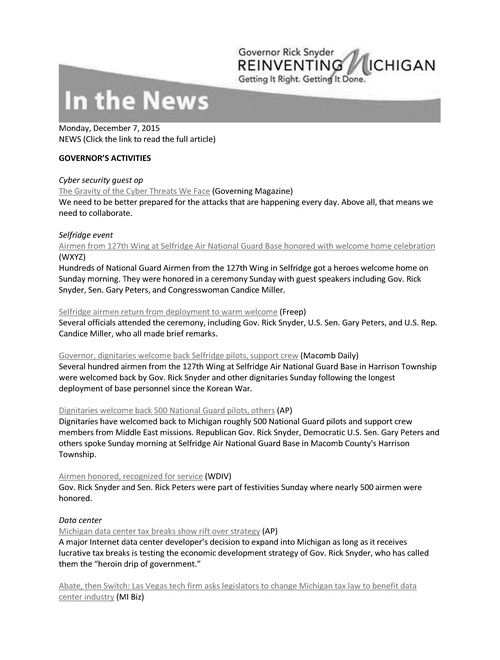

DIT determined DTMB033_2987.jp2 is a(n) scientific report in 2.28 seconds.
Donut determined DTMB033_2987.jp2 is a(n) email in 83.04 seconds.


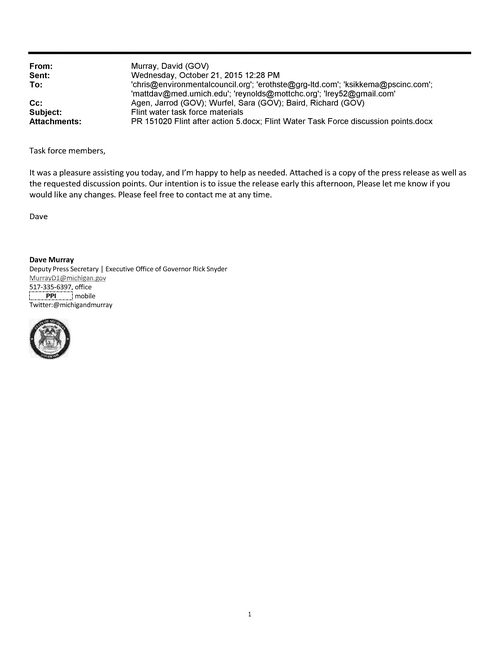

DIT determined GOV004_4140.jp2 is a(n) email in 1.30 seconds.
Donut determined GOV004_4140.jp2 is a(n) email in 82.90 seconds.


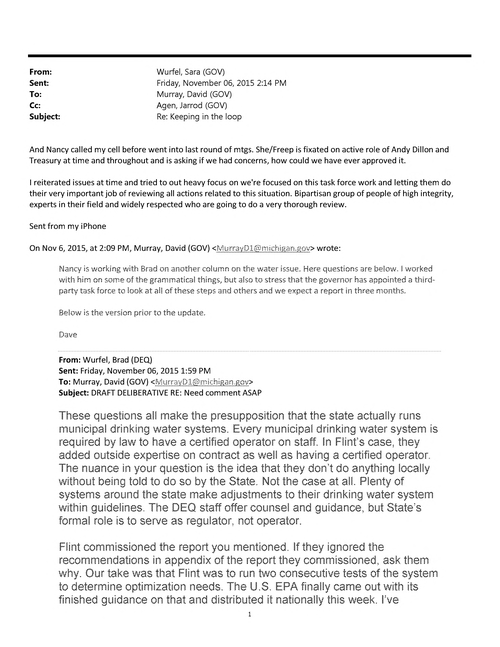

DIT determined GOV004_4171.jp2 is a(n) email in 1.55 seconds.
Donut determined GOV004_4171.jp2 is a(n) email in 84.24 seconds.


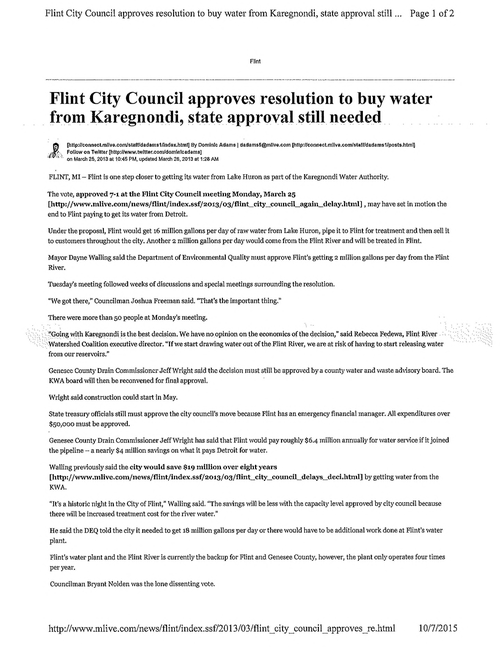

DIT determined Staff_1_0757.jp2 is a(n) news article in 1.45 seconds.
Donut determined Staff_1_0757.jp2 is a(n) news_article in 88.99 seconds.


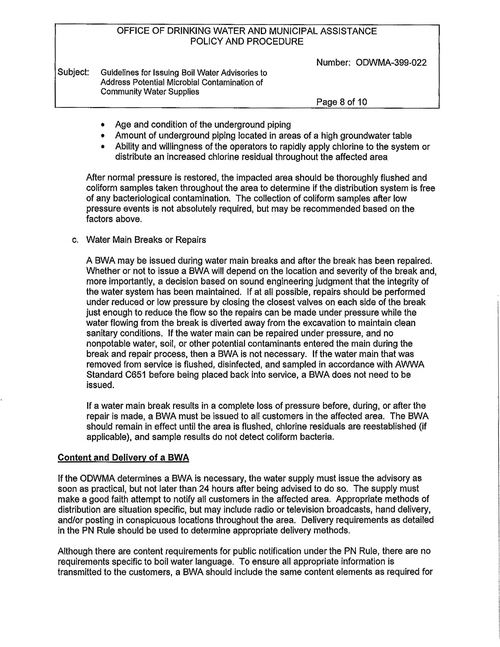

DIT determined Staff_1_0868.jp2 is a(n) email in 1.74 seconds.
Donut determined Staff_1_0868.jp2 is a(n) scientific_report in 85.72 seconds.


In [9]:
# should we run donut? (It takes a long time...)
run_donut = True

for filename in sample_image_filenames:
  show_image_preview(filename)

  dit_tic = time.time()
  dit_result = get_class_of_image_from_dit(filename)
  dit_time = time.time() - dit_tic
  print(f"DIT determined {filename} is a(n) {dit_result} in {dit_time:.2f} seconds.")

  if run_donut:
    donut_tic = time.time()
    donut_result = get_class_of_image_from_donut(filename)
    donut_time = time.time() - donut_tic
    print(f"Donut determined {filename} is a(n) {donut_result} in {donut_time:.2f} seconds.")